### Posterior of waiting time distributions <a id='section_TOP'></a>

- A  [Minimal models](#section_A)
- B  [Par3 models](#section_B)
- C  [Example calculation for Highest density intervals (HDIs)](#section_C)
- D  [General note on model probabilities](#section_D)

In [1]:
import memo_py as me
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import corner
%matplotlib inline

import scipy.stats as stats
from scipy import integrate
import pymc3

/Users/mlanghinrichs/Documents/Studium/MSc/09_hiwi_hoefer/01_project/memo_py/memo_py/selection.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### A Minimal models <a id='section_A'></a> [↑](#section_TOP)

In [7]:
# load some example model selection result
res = pickle.load(open('estimation_in_silico_data_cd44_sigma022_min2.pickle', 'rb'))
#print(res)

In [9]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
print(res[0].data.data_name)

steps_list = range(1, 21) # 11, 21

rows = [fr'$\lambda{i}$' for i in range(1, 21)]# range(1, 21)]
cols = [fr'$\alpha{i}$' for i in range(4, 8)]# range(1, 6)]

model_probs_2d = np.zeros((len(rows), len(cols)))

for i, row_step in enumerate(rows):
    for j, col_step in enumerate(cols):
        name = f'net_{steps_list[j]}_{steps_list[i]}'
        net_index = net_names.index(name)
        model_probs_2d[i, j] = model_probs[net_index]

df = pd.DataFrame(model_probs_2d * 100.0, index=rows, columns=cols)

plt.figure(figsize=(6, 8))
sns.heatmap(df, cmap='plasma', annot=True, fmt='.1f') # annot=True
plt.yticks(rotation=0, va='center')
# plt.savefig('./example_figures/map_model_probs.pdf')

in_silico_data_cd44_sigma022


ValueError: 'net_1_1' is not in list

In [26]:
# check that model prob distr sums to 1
print(sum(model_probs))

# this way we can sample random models from model_probs
net_ind = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
print(net_ind, net_names[net_ind])

est = res[net_ind]

1.0
0 net_alphaF6_alphaS6_alphaT14_lambda18 <memo_py.estimation.Estimation object at 0x7fab8499c7d0>


In [29]:
est.net.net_modules

[{'module': 'module_0',
  'start-end': ('M_t', 'A_t'),
  'start-end_ident': ('Z_1', 'Z_0'),
  'sym_rate': 'd_ma',
  'sym_rate_ident': 'theta_0',
  'type': 'S -> E',
  'module_steps': 3},
 {'module': 'module_1',
  'start-end': ('A_t', 'A_t'),
  'start-end_ident': ('Z_0', 'Z_0'),
  'sym_rate': 'la_a',
  'sym_rate_ident': 'theta_1',
  'type': 'S -> S + S',
  'module_steps': 10}]

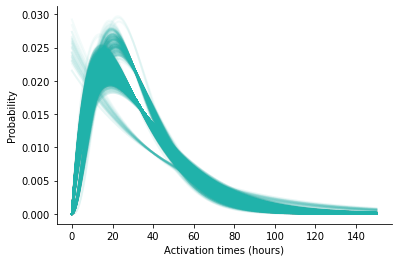

In [6]:
samples = 5000

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# set general x values
x = np.linspace(0.0, 150.0, num=200)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### activation reaction ###
    theta_shape = est.net.net_modules[0]['module_steps']
    theta_scale = 1.0/(theta[0]*theta_shape)

    # plot on top
    plt.plot(x, stats.gamma.pdf(x, a=theta_shape, scale=theta_scale),
                 color='lightseagreen', lw=2, alpha=0.05)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act.png') # pdf, png
plt.show()

Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):
y_median:  0.9999100054102069
y_lower:  0.9612883002636582
y_upper:  1.0385223963852854


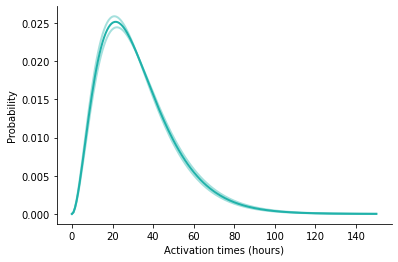

In [4]:
# idea to compute "credible bands" for better visualisation
samples = 20000

# set general x values
x = np.linspace(0.0, 150.0, num=200)
y = np.zeros((x.shape[0], samples))

for i in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### activation reaction ###
    theta_shape = est.net.net_modules[0]['module_steps']
    theta_scale = 1.0/(theta[0]*theta_shape)
    
    y[:, i] = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)

# this is also known as equally-tailed interval (ETI)
y_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_upper = np.percentile(y, 97.5, axis=1)

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(x, y_lower, color='lightseagreen', lw=2, alpha=0.4)
plt.plot(x, y_median, color='lightseagreen', lw=2)
plt.plot(x, y_upper, color='lightseagreen', lw=2, alpha=0.4)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act.pdf') # pdf, png

# check on median integral (ideally = 1.0)
print('Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):')
print('y_median: ', integrate.simps(y_median, x))
print('y_lower: ', integrate.simps(y_lower, x))
print('y_upper: ', integrate.simps(y_upper, x))

/Users/m651s/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


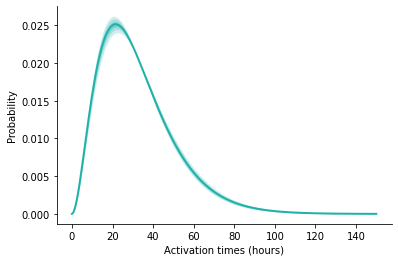

In [5]:
# based on y from previous block, calculate high density interval (HDI)
# IMPORTANT NOTE: the implementation works only for unimodal distributions
y_hdi_997_lower = np.zeros(y.shape[0])
y_hdi_997_upper = np.zeros(y.shape[0])
y_hdi_95_lower = np.zeros(y.shape[0])
y_hdi_95_upper = np.zeros(y.shape[0])
y_hdi_68_lower = np.zeros(y.shape[0])
y_hdi_68_upper = np.zeros(y.shape[0])

# compute HDIs pointwise for each time point (x value)
for time_i in range(y.shape[0]):
    hdi_997 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.997)
    hdi_95 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.95)
    hdi_68 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.68)
    
    y_hdi_997_lower[time_i] = hdi_997[0]
    y_hdi_997_upper[time_i] = hdi_997[1]
    
    y_hdi_95_lower[time_i] = hdi_95[0]
    y_hdi_95_upper[time_i] = hdi_95[1]
    
    y_hdi_68_lower[time_i] = hdi_68[0]
    y_hdi_68_upper[time_i] = hdi_68[1]
    

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.fill_between(x, y_hdi_997_lower, y_hdi_95_lower, color='lightseagreen', alpha=0.2, linewidth=0.0)
plt.fill_between(x, y_hdi_95_lower, y_hdi_68_lower, color='lightseagreen', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_68_lower, y_median, color='lightseagreen', alpha=0.6, linewidth=0.0)

plt.fill_between(x, y_median, y_hdi_68_upper, color='lightseagreen', alpha=0.6, linewidth=0.0)
plt.fill_between(x, y_hdi_68_upper, y_hdi_95_upper, color='lightseagreen', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_95_upper, y_hdi_997_upper, color='lightseagreen', alpha=0.2, linewidth=0.0)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color='lightseagreen', lw=2)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act_hdi.pdf') # pdf, png


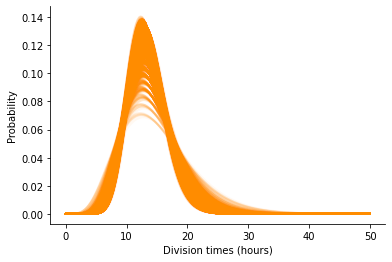

In [5]:
samples = 5000

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# set general x values
x = np.linspace(0.0, 50.0, num=200)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### division reaction ###
    theta_shape = est.net.net_modules[1]['module_steps']
    theta_scale = 1.0/(theta[1]*theta_shape)

    # plot on top
    plt.plot(x, stats.gamma.pdf(x, a=theta_shape, scale=theta_scale),
                 color='darkorange', lw=2, alpha=0.05)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div.png') # pdf, png
plt.show()

Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):
y_median:  0.9976793922169508
y_lower:  0.7714833697514936
y_upper:  1.2385020216095004


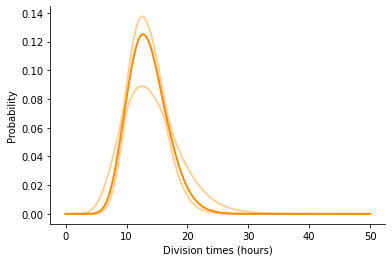

In [6]:
# idea to compute "credible bands" for better visualisation
samples = 20000

# set general x values
x = np.linspace(0.0, 50.0, num=200)
y = np.zeros((x.shape[0], samples))

for i in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### division reaction ###
    theta_shape = est.net.net_modules[1]['module_steps']
    theta_scale = 1.0/(theta[1]*theta_shape)
    
    y[:, i] = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
    
y_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_upper = np.percentile(y, 97.5, axis=1)

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.plot(x, y_lower, color='darkorange', lw=2, alpha=0.4)
plt.plot(x, y_median, color='darkorange', lw=2)
plt.plot(x, y_upper, color='darkorange', lw=2, alpha=0.4)
plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div.pdf') # pdf, png

# check on median integral (ideally = 1.0)
print('Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):')
print('y_median: ', integrate.simps(y_median, x))
print('y_lower: ', integrate.simps(y_lower, x))
print('y_upper: ', integrate.simps(y_upper, x))

/Users/m651s/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


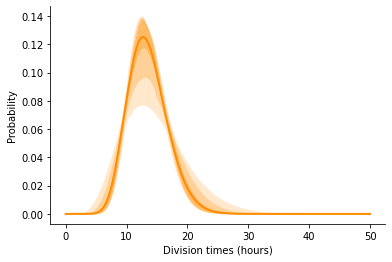

In [7]:
# based on y from previous block, calculate high density interval (HDI)
# IMPORTANT NOTE: the implementation works only for unimodal distributions
y_hdi_997_lower = np.zeros(y.shape[0])
y_hdi_997_upper = np.zeros(y.shape[0])
y_hdi_95_lower = np.zeros(y.shape[0])
y_hdi_95_upper = np.zeros(y.shape[0])
y_hdi_68_lower = np.zeros(y.shape[0])
y_hdi_68_upper = np.zeros(y.shape[0])

# compute HDIs pointwise for each time point (x value)
for time_i in range(y.shape[0]):
    hdi_997 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.997)
    hdi_95 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.95)
    hdi_68 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.68)
    
    y_hdi_997_lower[time_i] = hdi_997[0]
    y_hdi_997_upper[time_i] = hdi_997[1]
    
    y_hdi_95_lower[time_i] = hdi_95[0]
    y_hdi_95_upper[time_i] = hdi_95[1]
    
    y_hdi_68_lower[time_i] = hdi_68[0]
    y_hdi_68_upper[time_i] = hdi_68[1]
    

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.fill_between(x, y_hdi_997_lower, y_hdi_95_lower, color='darkorange', alpha=0.2, linewidth=0.0)
plt.fill_between(x, y_hdi_95_lower, y_hdi_68_lower, color='darkorange', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_68_lower, y_median, color='darkorange', alpha=0.6, linewidth=0.0)

plt.fill_between(x, y_median, y_hdi_68_upper, color='darkorange', alpha=0.6, linewidth=0.0)
plt.fill_between(x, y_hdi_68_upper, y_hdi_95_upper, color='darkorange', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_95_upper, y_hdi_997_upper, color='darkorange', alpha=0.2, linewidth=0.0)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='darkorange', lw=2, alpha=0.6)
plt.plot(x, y_median, color='darkorange', lw=2)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div_hdi.pdf') # pdf, png

#### B Par3 models <a id='section_B'></a> [↑](#section_TOP)

In [2]:
# load some example model selection result
res = pickle.load(open('estimation_count_data_cd44_filtered_thin4_par3.pickle', 'rb'))
data = res[0].data
#print(res)
#print(data)

In [3]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
logevids = [est.bay_est_log_evidence for est in res]
max(logevids)

42.13480758579131

In [4]:
list(model_probs).index(max(model_probs))

348

In [17]:
print(logevids[370])
net_names[370]

42.13480758579131


'net_alphaF6_alphaS6_alphaT14_lambda18'

In [61]:
for name, logevid in zip(net_names, logevids):
    if logevid > 235.5:
        print(name, '\t',logevid)

net_alphaF4_alphaS6_alphaT6_lambda18 	 235.6161915698925
net_alphaF6_alphaS6_alphaT6_lambda10 	 235.5303575767128
net_alphaF6_alphaS6_alphaT6_lambda14 	 235.88771464915
net_alphaF6_alphaS6_alphaT6_lambda18 	 235.7986712420933
net_alphaF6_alphaS6_alphaT14_lambda14 	 235.56732529582533
net_alphaF6_alphaS6_alphaT18_lambda18 	 235.5434805195489
net_alphaF6_alphaS8_alphaT14_lambda14 	 235.50951620423467
net_alphaF8_alphaS8_alphaT18_lambda14 	 235.6722507085798
net_alphaF8_alphaS8_alphaT18_lambda18 	 235.56980755012884


In [20]:
# overwrite res if you want to sample from single model
res = [res[370]]
est = res[0]
print(est.net.net_name)


IndexError: list index out of range

In [5]:
net_names = [est.net.net_name for est in res]
model_probs = me.selection.compute_model_probabilities(res)
logevids = [est.bay_est_log_evidence for est in res]
# print(net_names, model_probs, logevids)

In [64]:
net_names.index('net_alphaF6_alphaS8_alphaT14_lambda14')

397

In [69]:
est.net.net_modules

[{'module': 'module_0',
  'start-end': ('N_t', 'P1_t'),
  'start-end_ident': ('Z_1', 'Z_2'),
  'sym_rate': 'alpha_F',
  'sym_rate_ident': 'theta_0',
  'type': 'S -> E',
  'module_steps': 3},
 {'module': 'module_1',
  'start-end': ('P1_t', 'A_t'),
  'start-end_ident': ('Z_2', 'Z_0'),
  'sym_rate': 'alpha_F',
  'sym_rate_ident': 'theta_0',
  'type': 'S -> E',
  'module_steps': 3},
 {'module': 'module_2',
  'start-end': ('N_t', 'P2_t'),
  'start-end_ident': ('Z_1', 'Z_3'),
  'sym_rate': 'alpha_S',
  'sym_rate_ident': 'theta_1',
  'type': 'S -> E',
  'module_steps': 4},
 {'module': 'module_3',
  'start-end': ('P2_t', 'A_t'),
  'start-end_ident': ('Z_3', 'Z_0'),
  'sym_rate': 'alpha_S',
  'sym_rate_ident': 'theta_1',
  'type': 'S -> E',
  'module_steps': 4},
 {'module': 'module_4',
  'start-end': ('N_t', 'P3_t'),
  'start-end_ident': ('Z_1', 'Z_4'),
  'sym_rate': 'alpha_T',
  'sym_rate_ident': 'theta_2',
  'type': 'S -> E',
  'module_steps': 7},
 {'module': 'module_5',
  'start-end': ('P3_t

In [86]:
model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
model_rand

370

In [87]:
inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
theta_ind = np.random.choice(inds, replace=True)
theta = est.bay_est_samples_weighted[theta_ind, :]
theta

array([0.08524725, 0.01526322, 0.00232762, 0.07343203])

net_alphaF6_alphaS6_alphaT10_lambda14
[0.08864903 0.0231434  0.00838701 0.07414459]
3
3
5
0.088649029987878
0.023143398975722082
0.008387012894303594
0.7048459691377966
0.1840125208636363
0.11114150999856715


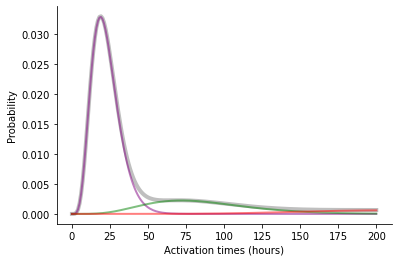

In [14]:
samples = 1

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# set general x values
x = np.linspace(0.0, 200.0, num=200)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    print(est.net.net_name)
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    print(theta)
    
    # read out steps for the first half of the channels (by construction)
    alpha_F_steps = est.net.net_modules[0]['module_steps']
    alpha_S_steps = est.net.net_modules[2]['module_steps']
    alpha_T_steps = est.net.net_modules[4]['module_steps']
    print(alpha_F_steps)
    print(alpha_S_steps)
    print(alpha_T_steps)
    
    # read out rates for the first half of the channels (by construction)
    alpha_F_rate = theta[0]
    alpha_S_rate = theta[1]
    alpha_T_rate = theta[2]
    print(alpha_F_rate)
    print(alpha_S_rate)
    print(alpha_T_rate)
    
    # calculate channel probabilities
    alpha_total_paths = alpha_F_steps * alpha_F_rate + alpha_S_steps * alpha_S_rate + alpha_T_steps * alpha_T_rate
    alpha_F_path = (alpha_F_steps * alpha_F_rate)/alpha_total_paths
    alpha_S_path = (alpha_S_steps * alpha_S_rate)/alpha_total_paths
    alpha_T_path = (alpha_T_steps * alpha_T_rate)/alpha_total_paths
    print(alpha_F_path)
    print(alpha_S_path)
    print(alpha_T_path)
    
    # calculate different gamma pdfs
    alpha_F_shape = alpha_F_steps * 2
    alpha_F_scale = 1.0/(0.5*alpha_F_rate*alpha_F_shape)
    
    alpha_S_shape = alpha_S_steps * 2
    alpha_S_scale = 1.0/(0.5*alpha_S_rate*alpha_S_shape)
    
    alpha_T_shape = alpha_T_steps * 2
    alpha_T_scale = 1.0/(0.5*alpha_T_rate*alpha_T_shape)
    
    alpha_F_gamma = stats.gamma.pdf(x, a=alpha_F_shape, scale=alpha_F_scale)
    alpha_S_gamma = stats.gamma.pdf(x, a=alpha_S_shape, scale=alpha_S_scale)
    alpha_T_gamma = stats.gamma.pdf(x, a=alpha_T_shape, scale=alpha_T_scale)
    
    # compose total gamma over channels
    gamma = alpha_F_path * alpha_F_gamma + alpha_S_path * alpha_S_gamma + alpha_T_path * alpha_T_gamma
    
    # some consistency checks
    if not est.net.net_modules[0]['sym_rate']=='alpha_F':
        print('error')
    if not est.net.net_modules[2]['sym_rate']=='alpha_S':
        print('error')
    if not est.net.net_modules[4]['sym_rate']=='alpha_T':
        print('error')

    # plot on top
    plt.plot(x, gamma,
                 'grey', lw=4, alpha=0.5)
    
    plt.plot(x, alpha_F_path * alpha_F_gamma,
                 'purple', lw=2, alpha=0.5)
    plt.plot(x, alpha_S_path * alpha_S_gamma,
                 'green', lw=2, alpha=0.5)
    plt.plot(x, alpha_T_path * alpha_T_gamma,
                 'red', lw=2, alpha=0.5)
    
    
    
plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_gamma_compose_act.pdf')
plt.show()

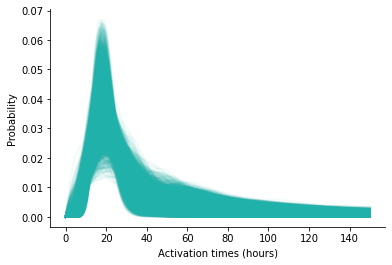

In [5]:
samples = 5000

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# set general x values
x = np.linspace(0.0, 150.0, num=200)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # read out steps for the first half of the channels (by construction)
    alpha_F_steps = est.net.net_modules[0]['module_steps']
    alpha_S_steps = est.net.net_modules[2]['module_steps']
    alpha_T_steps = est.net.net_modules[4]['module_steps']
    
    # read out rates for the first half of the channels (by construction)
    alpha_F_rate = theta[0]
    alpha_S_rate = theta[1]
    alpha_T_rate = theta[2]
    
    # calculate channel probabilities
    alpha_total_paths = alpha_F_steps * alpha_F_rate + alpha_S_steps * alpha_S_rate + alpha_T_steps * alpha_T_rate
    alpha_F_path = (alpha_F_steps * alpha_F_rate)/alpha_total_paths
    alpha_S_path = (alpha_S_steps * alpha_S_rate)/alpha_total_paths
    alpha_T_path = (alpha_T_steps * alpha_T_rate)/alpha_total_paths
    
    # calculate different gamma pdfs
    alpha_F_shape = alpha_F_steps * 2
    alpha_F_scale = 1.0/(0.5*alpha_F_rate*alpha_F_shape)
    
    alpha_S_shape = alpha_S_steps * 2
    alpha_S_scale = 1.0/(0.5*alpha_S_rate*alpha_S_shape)
    
    alpha_T_shape = alpha_T_steps * 2
    alpha_T_scale = 1.0/(0.5*alpha_T_rate*alpha_T_shape)
    
    alpha_F_gamma = stats.gamma.pdf(x, a=alpha_F_shape, scale=alpha_F_scale)
    alpha_S_gamma = stats.gamma.pdf(x, a=alpha_S_shape, scale=alpha_S_scale)
    alpha_T_gamma = stats.gamma.pdf(x, a=alpha_T_shape, scale=alpha_T_scale)
    
    # compose total gamma over channels
    gamma = alpha_F_path * alpha_F_gamma + alpha_S_path * alpha_S_gamma + alpha_T_path * alpha_T_gamma
    
    # some consistency checks
    if not est.net.net_modules[0]['sym_rate']=='alpha_F':
        print('error')
    if not est.net.net_modules[2]['sym_rate']=='alpha_S':
        print('error')
    if not est.net.net_modules[4]['sym_rate']=='alpha_T':
        print('error')

    # plot on top
    plt.plot(x, gamma,
                 'lightseagreen', lw=2, alpha=0.05)
    

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act.png') # pdf, png
plt.show()

Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):
y_median:  0.7347499331292431
y_lower:  0.36754479941994983
y_upper:  1.2066773204419863


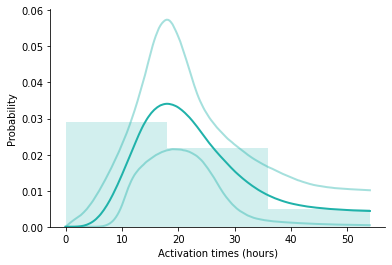

In [7]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
time_max = 54.0 # 150.0, 54.0

# set general x values
x = np.linspace(0.0, time_max, num=200)
y = np.zeros((x.shape[0], samples))

for i in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # read out steps for the first half of the channels (by construction)
    alpha_F_steps = est.net.net_modules[0]['module_steps']
    alpha_S_steps = est.net.net_modules[2]['module_steps']
    alpha_T_steps = est.net.net_modules[4]['module_steps']
    
    # read out rates for the first half of the channels (by construction)
    alpha_F_rate = theta[0]
    alpha_S_rate = theta[1]
    alpha_T_rate = theta[2]
    
    # calculate channel probabilities
    alpha_total_paths = alpha_F_steps * alpha_F_rate + alpha_S_steps * alpha_S_rate + alpha_T_steps * alpha_T_rate
    alpha_F_path = (alpha_F_steps * alpha_F_rate)/alpha_total_paths
    alpha_S_path = (alpha_S_steps * alpha_S_rate)/alpha_total_paths
    alpha_T_path = (alpha_T_steps * alpha_T_rate)/alpha_total_paths
    
    # calculate different gamma pdfs
    alpha_F_shape = alpha_F_steps * 2
    alpha_F_scale = 1.0/(0.5*alpha_F_rate*alpha_F_shape)
    
    alpha_S_shape = alpha_S_steps * 2
    alpha_S_scale = 1.0/(0.5*alpha_S_rate*alpha_S_shape)
    
    alpha_T_shape = alpha_T_steps * 2
    alpha_T_scale = 1.0/(0.5*alpha_T_rate*alpha_T_shape)
    
    alpha_F_gamma = stats.gamma.pdf(x, a=alpha_F_shape, scale=alpha_F_scale)
    alpha_S_gamma = stats.gamma.pdf(x, a=alpha_S_shape, scale=alpha_S_scale)
    alpha_T_gamma = stats.gamma.pdf(x, a=alpha_T_shape, scale=alpha_T_scale)
    
    # compose total gamma over channels
    gamma = alpha_F_path * alpha_F_gamma + alpha_S_path * alpha_S_gamma + alpha_T_path * alpha_T_gamma
    
    y[:, i] = gamma
    
y_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_upper = np.percentile(y, 97.5, axis=1)

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='lightseagreen', alpha=0.2,
             density=True, histtype='stepfilled')
    
plt.plot(x, y_lower, color='lightseagreen', lw=2, alpha=0.4)
plt.plot(x, y_median, color='lightseagreen', lw=2)
plt.plot(x, y_upper, color='lightseagreen', lw=2, alpha=0.4)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act.pdf') # pdf, png

# check on median integral (ideally = 1.0)
print('Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):')
print('y_median: ', integrate.simps(y_median, x))
print('y_lower: ', integrate.simps(y_lower, x))
print('y_upper: ', integrate.simps(y_upper, x))

/Users/m651s/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


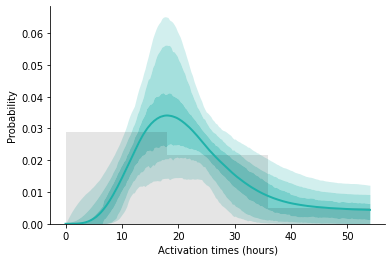

In [8]:
# based on y from previous block, calculate high density interval (HDI)
# IMPORTANT NOTE: the implementation works only for unimodal distributions
y_hdi_997_lower = np.zeros(y.shape[0])
y_hdi_997_upper = np.zeros(y.shape[0])
y_hdi_95_lower = np.zeros(y.shape[0])
y_hdi_95_upper = np.zeros(y.shape[0])
y_hdi_68_lower = np.zeros(y.shape[0])
y_hdi_68_upper = np.zeros(y.shape[0])

# compute HDIs pointwise for each time point (x value)
for time_i in range(y.shape[0]):
    hdi_997 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.997)
    hdi_95 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.95)
    hdi_68 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.68)
    
    y_hdi_997_lower[time_i] = hdi_997[0]
    y_hdi_997_upper[time_i] = hdi_997[1]
    
    y_hdi_95_lower[time_i] = hdi_95[0]
    y_hdi_95_upper[time_i] = hdi_95[1]
    
    y_hdi_68_lower[time_i] = hdi_68[0]
    y_hdi_68_upper[time_i] = hdi_68[1]
    

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')


plt.fill_between(x, y_hdi_997_lower, y_hdi_95_lower, color='lightseagreen', alpha=0.2, linewidth=0.0)
plt.fill_between(x, y_hdi_95_lower, y_hdi_68_lower, color='lightseagreen', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_68_lower, y_median, color='lightseagreen', alpha=0.6, linewidth=0.0)

plt.fill_between(x, y_median, y_hdi_68_upper, color='lightseagreen', alpha=0.6, linewidth=0.0)
plt.fill_between(x, y_hdi_68_upper, y_hdi_95_upper, color='lightseagreen', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_95_upper, y_hdi_997_upper, color='lightseagreen', alpha=0.2, linewidth=0.0)

# plt.plot(x, y_hdi_997_lower, color='lightseagreen', lw=2, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='lightseagreen', lw=2, alpha=0.6)
plt.plot(x, y_median, color='lightseagreen', lw=2)
# plt.plot(x, y_hdi_68_upper, color='lightseagreen', lw=2, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='lightseagreen', lw=2, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='lightseagreen', lw=2, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Activation times (hours)')
plt.savefig('waiting_times_act_hdi.pdf') # pdf, png

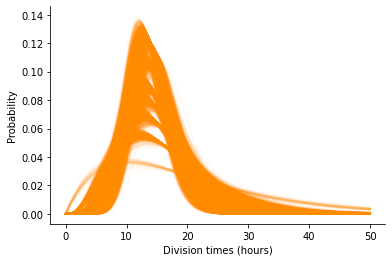

In [11]:
samples = 5000

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# set general x values
x = np.linspace(0.0, 50.0, num=200)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### division reaction ###
    theta_shape = est.net.net_modules[6]['module_steps']
    theta_scale = 1.0/(theta[3]*theta_shape)
    
    if not est.net.net_modules[6]['sym_rate']=='lambda':
        print('error')

    # plot on top
    plt.plot(x, stats.gamma.pdf(x, a=theta_shape, scale=theta_scale),
                 color='darkorange', lw=2, alpha=0.05)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div.png') # pdf, png
plt.show()

Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):
y_median:  0.9957330179558719
y_lower:  0.6871884689314472
y_upper:  1.3364731348232846


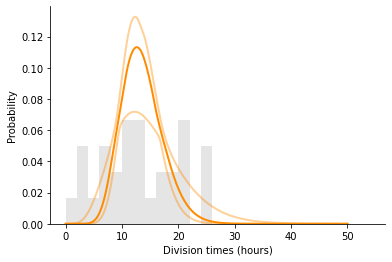

In [6]:
# idea to compute "credible bands" for better visualisation
samples = 20000
plot_data = True # True or False
# NOTE: the data we plot here is only from first divisions! (so its not the complete data, 
# which is inaccessible from the data)

# set general x values
x = np.linspace(0.0, 50.0, num=200)
y = np.zeros((x.shape[0], samples))

for i in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    # get random theta according to p(theta|M, D)
    inds = np.array(range(0, est.bay_est_samples_weighted.shape[0]))
    theta_ind = np.random.choice(inds, replace=True)
    theta = est.bay_est_samples_weighted[theta_ind, :]
    
    # compute Gamma parameters
    ### division reaction ###
    theta_shape = est.net.net_modules[6]['module_steps']
    theta_scale = 1.0/(theta[3]*theta_shape)
    
    y[:, i] = stats.gamma.pdf(x, a=theta_shape, scale=theta_scale)
    
y_lower = np.percentile(y, 2.5, axis=1)
y_median = np.percentile(y, 50.0, axis=1)
y_upper = np.percentile(y, 97.5, axis=1)

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.plot(x, y_lower, color='darkorange', lw=2, alpha=0.4)
plt.plot(x, y_median, color='darkorange', lw=2)
plt.plot(x, y_upper, color='darkorange', lw=2, alpha=0.4)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div.pdf') # pdf, png

# check on median integral (ideally = 1.0)
print('Integral of median waiting time distr (plot can be misleading, if it deviates strongly from 1.0):')
print('y_median: ', integrate.simps(y_median, x))
print('y_lower: ', integrate.simps(y_lower, x))
print('y_upper: ', integrate.simps(y_upper, x))

/Users/m651s/opt/anaconda3/envs/cd44_project/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


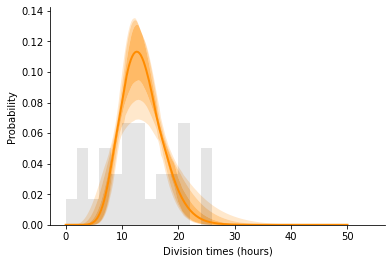

In [7]:
# based on y from previous block, calculate high density interval (HDI)
# IMPORTANT NOTE: the implementation works only for unimodal distributions
y_hdi_997_lower = np.zeros(y.shape[0])
y_hdi_997_upper = np.zeros(y.shape[0])
y_hdi_95_lower = np.zeros(y.shape[0])
y_hdi_95_upper = np.zeros(y.shape[0])
y_hdi_68_lower = np.zeros(y.shape[0])
y_hdi_68_upper = np.zeros(y.shape[0])

# compute HDIs pointwise for each time point (x value)
for time_i in range(y.shape[0]):
    hdi_997 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.997)
    hdi_95 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.95)
    hdi_68 = pymc3.stats.hpd(y[time_i, :], hdi_prob=.68)
    
    y_hdi_997_lower[time_i] = hdi_997[0]
    y_hdi_997_upper[time_i] = hdi_997[1]
    
    y_hdi_95_lower[time_i] = hdi_95[0]
    y_hdi_95_upper[time_i] = hdi_95[1]
    
    y_hdi_68_lower[time_i] = hdi_68[0]
    y_hdi_68_upper[time_i] = hdi_68[1]
    

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# adapted from framework plotting methods
if plot_data:
    data.events_find_all()
    data_act = np.array([tup[1] for tup in data.event_all_first_cell_count_increase_after_cell_type_conversion if tup[0]])

    plt.hist(data_act - 1e-06, bins=data.data_time_values,
             color='black', alpha=0.1,
             density=True, histtype='stepfilled')
    
plt.fill_between(x, y_hdi_997_lower, y_hdi_95_lower, color='darkorange', alpha=0.2, linewidth=0.0)
plt.fill_between(x, y_hdi_95_lower, y_hdi_68_lower, color='darkorange', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_68_lower, y_median, color='darkorange', alpha=0.6, linewidth=0.0)

plt.fill_between(x, y_median, y_hdi_68_upper, color='darkorange', alpha=0.6, linewidth=0.0)
plt.fill_between(x, y_hdi_68_upper, y_hdi_95_upper, color='darkorange', alpha=0.4, linewidth=0.0)
plt.fill_between(x, y_hdi_95_upper, y_hdi_997_upper, color='darkorange', alpha=0.2, linewidth=0.0)

# plt.plot(x, y_hdi_997_lower, color='darkorange', lw=0.5, alpha=0.2)
# plt.plot(x, y_hdi_95_lower, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_68_lower, color='blue', lw=0.5, alpha=0.6)
plt.plot(x, y_median, color='darkorange', lw=2)
# plt.plot(x, y_hdi_68_upper, color='darkorange', lw=0.5, alpha=0.6)
# plt.plot(x, y_hdi_95_upper, color='darkorange', lw=0.5, alpha=0.4)
# plt.plot(x, y_hdi_997_upper, color='darkorange', lw=0.5, alpha=0.2)

plt.ylabel('Probability')
plt.xlabel('Division times (hours)')
plt.savefig('waiting_times_div_hdi.pdf') # pdf, png

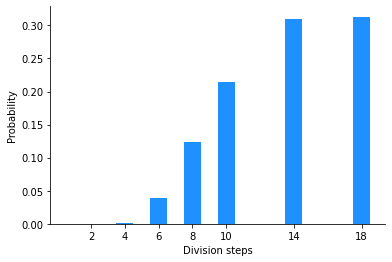

In [6]:
samples = 10000
div_steps = list()

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    div_steps.append(est.net.net_modules[6]['module_steps'])
    
    if not est.net.net_modules[6]['sym_rate']=='lambda':
        print('error')

plt.hist(np.array(div_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Division steps')
plt.savefig('waiting_times_div_steps.pdf')
plt.show()

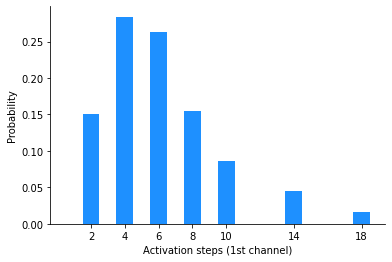

In [4]:
samples = 50000
alpha_steps = list()

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    alpha_steps.append(2 * est.net.net_modules[0]['module_steps'])
    
    if not est.net.net_modules[0]['sym_rate']=='alpha_F':
        print('error')

plt.hist(np.array(alpha_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Activation steps (1st channel)')
plt.savefig('waiting_times_act_steps.pdf')
plt.show()

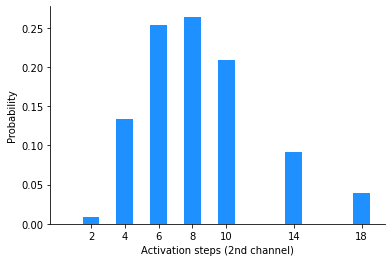

In [5]:
samples = 50000
alpha_steps = list()

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    alpha_steps.append(2 * est.net.net_modules[3]['module_steps'])
    
    if not est.net.net_modules[3]['sym_rate']=='alpha_S':
        print('error')

plt.hist(np.array(alpha_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Activation steps (2nd channel)')
plt.savefig('waiting_times_act_steps.pdf')
plt.show()

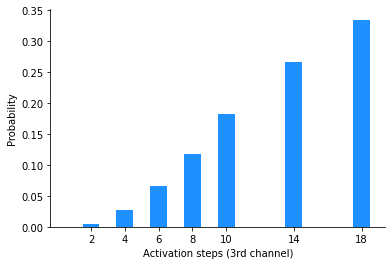

In [6]:
samples = 50000
alpha_steps = list()

plt.figure()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

for __ in range(samples):
    # get random model according to p(M|D)
    model_rand = np.random.choice(range(len(model_probs)), p=model_probs, replace=True)
    est = res[model_rand]
    
    alpha_steps.append(2 * est.net.net_modules[5]['module_steps'])
    
    if not est.net.net_modules[5]['sym_rate']=='alpha_T':
        print('error')

plt.hist(np.array(alpha_steps), bins=np.linspace(1, 19, endpoint=True, num=19)-0.5, 
         density=True, color='dodgerblue')
plt.xticks([2, 4, 6, 8, 10, 14, 18])
plt.ylabel('Probability')
plt.xlabel('Activation steps (3rd channel)')
plt.savefig('waiting_times_act_steps.pdf')
plt.show()

#### C Example calculation for Highest density intervals (HDIs) <a id='section_C'></a> [↑](#section_TOP)

see here: https://www.sciencedirect.com/topics/mathematics/highest-density-interval

In [14]:
# small check and code example on normal random samples
import numpy as np
import pymc3

data = np.random.normal(size=100000)

# bounds should be mean +/- sigma = +/- 1
print(pymc3.stats.hpd(data, hdi_prob=.6827))

# bounds should be mean +/- 2 sigma = +/- 2
print(pymc3.stats.hpd(data, hdi_prob=.9545))

# bounds should be mean +/- 3 sigma = +/- 3
print(pymc3.stats.hpd(data, hdi_prob=.9973))

[-0.99483318  0.99731409]
[-1.98350951  2.01640513]
[-2.9824583   2.99731324]


#### D Note on the model probability distribution <a id='section_D'></a> [↑](#section_TOP)

Assume we have two models A and B with logEvidence of 20 and 22, respectively.
Their model probability distribution is calculated below (A: 12% and B: 88%).

Now we duplicate the first model; we just add another logEvidence of 20 to the selection list (A, A, B).
What is the new model probability distribution? Naively, one would assume 6%, 6% and 88%, because adding the same model again should not change the overall probability of getting models A or B.

But this is wrong, as we see the model probabilities become 11%, 11% and 79% (ignore round error).

This is of course a paradoxon, the problem is that in all cases so far we have our currently "unchallenged" assumption of the *uniform* model prior: for two models (1/2, 1/2) and for three models (1/3, 1/3, 1/3).

To actually obtain the naively expected result, we have to express our prior belief in A and B accordingly. A and B are essentially the only two models considered, so their prior is (1/2), (1/2). For the model selection (A, A, B) we should then rather use the prior (1/4, 1/4, 1/2), because A maintains 1/2 prior belief.

With this adaption, it can indeed be seen that the naively expected model probabities arise when duplicating A: 6%, 6% and 88%, making total A: 12% probable and B: 88%.


**Implications?** Think about how we constructed our '3-parallel' activation channel model selection. To keep the model space a bit smaller, we have removed model symmetries. Removing a model symmetry is like running (A, B) instead of (A, A, B). So running the model selection with or without these symmetries has an effect of the final model probabilities (when not adapting the uniform model prior)! It is of course hard to say, what the more appropriate way is.

In [4]:
### code snippet copied/adapted from selection.py
### method compute_model_probabilities(estimation_instances)

logevids = np.array([20, 22])

# log model prior (log of model number)
# assuming uniform model prior
logmprior = - np.log(logevids.shape[0])
print(logmprior)

# calculate normalising factor p(D)
logpdata = np.log(np.sum(np.exp(logevids))) + logmprior
print(logpdata)

# calculate model probabilities
probs = np.exp(logevids + logmprior - logpdata)

print(probs)
me.selection.compute_model_probabilities_from_log_evidences(logevids)

-0.6931471805599453
21.43378083048303
[0.11920292 0.88079708]


array([0.11920292, 0.88079708])

In [3]:
logevids = np.array([20, 20, 22])

logmprior = - np.log(logevids.shape[0])
print(logmprior)

logpdata = np.log(np.sum(np.exp(logevids))) + logmprior
print(logpdata)

probs = np.exp(logevids + logmprior - logpdata)

print(probs)
me.selection.compute_model_probabilities_from_log_evidences(logevids)

-1.0986122886681098
21.140932477553772
[0.10650698 0.10650698 0.78698604]


array([0.10650698, 0.10650698, 0.78698604])

In [7]:
logevids = np.array([20, 20, 22])

# model prior adapted to (1/4, 1/4, 1/2)
logmprior = np.array([- np.log(4), - np.log(4), - np.log(2)])
print(logmprior)

# have to also adapt calculation of p(D) a bit
logpdata = np.log(np.sum(np.exp(logevids) * np.exp(logmprior)))
print(logpdata)

# calculate model probabilities
probs = np.exp(logevids + logmprior - logpdata)

print(sum(probs[[0,1]]))
print(probs)

me.selection.compute_model_probabilities_from_log_evidences(logevids, mprior=np.exp(logmprior))

[-1.38629436 -1.38629436 -0.69314718]
21.433780830483027
0.11920292202211757
[0.05960146 0.05960146 0.88079708]


array([0.05960146, 0.05960146, 0.88079708])

In [15]:
# NEW calculation, added Aug 2020
# uses log-sum-exp trick to prevent overflow issue in logpdata calculation
# version can accept model-specific priors (not only general uniform prior)
# (is actually quite similar to an alternative version based on the bayes factors)
logevids = np.array([20, 20, 22])

# model prior adapted to (1/4, 1/4, 1/2)
mprior = np.array([1/4, 1/4, 1/2])
# mprior = np.array([1/3, 1/3, 1/3])
logmprior = np.log(mprior)
print(logmprior)

# calculate aggregate of evidences and model prior in logspace (an array)
logevidmprior = logevids + logmprior
print(logevidmprior)

# get maximal value to use log-sum-exp trick (a number)
logmax = np.max(logevidmprior)
print(logmax)

# calculate normalising factor p(D) using log-sum-exp trick (a number)
logpdata = logmax + np.log(np.sum(np.exp(logevidmprior - logmax)))
print(logpdata)

# calculate model probabilities (an array)
probs = np.exp(logevidmprior - logpdata)

print(sum(probs))
probs

[-1.38629436 -1.38629436 -0.69314718]
[18.61370564 18.61370564 21.30685282]
21.306852819440056
21.433780830483027
1.0000000000000018
0.11920292202211757


array([0.05960146, 0.05960146, 0.88079708])